## Part 1

In [1]:
from pathlib import Path
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map


sns.set_theme()

### with alpha = 0.8, gamma = 0.95, epsilon = 0.1

In [2]:
class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability
    map_size: int  # Number of tiles of one side of the squared environment
    seed: int  # Define a seed so that we get reproducible results
    is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    proba_frozen: float  # Probability that a tile is frozen
    savefig_folder: Path  # Root folder where plots are saved


params = Params(
    total_episodes=2000,
    learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,
    map_size=5,
    seed=123,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("../../_static/img/tutorials/"),
)
params

# Set the seed
rng = np.random.default_rng(params.seed)

# Create the figure folder if it doesn't exists
params.savefig_folder.mkdir(parents=True, exist_ok=True)

In [3]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)


In [4]:

params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")


class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((self.state_size, self.action_size))


class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        """Choose an action `a` in the current world state (s)."""
        # First we randomize a number
        explor_exploit_tradeoff = rng.uniform(0, 1)

        # Exploration
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        else:
            # Break ties randomly
            # If all actions are the same for this state we choose a random one
            # (otherwise `np.argmax()` would always take the first one)
            if np.all(qtable[state, :]) == qtable[state, 0]:
                action = action_space.sample()
            else:
                action = np.argmax(qtable[state, :])
        return action

Action size: 4
State size: 25


In [5]:
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)
explorer = EpsilonGreedy(
    epsilon=params.epsilon,
)

In [6]:
def run_env():
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):  # Run several times to account for stochasticity
        learner.reset_qtable()  # Reset the Q-table between runs

        for episode in tqdm(
            episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=params.seed)[0]  # Reset the environment
            step = 0
            done = False
            total_rewards = 0

            while not done:
                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                # Log all states and actions
                all_states.append(state)
                all_actions.append(action)

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )

                total_rewards += reward
                step += 1

                # Our new state is state
                state = new_state

            # Log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

In [7]:
def postprocess(episodes, params, rewards, steps, map_size):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(),
            "Steps": steps.flatten(),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st


In [8]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [9]:
def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

In [10]:
def plot_states_actions_distribution(states, actions, map_size):
    """Plot the distributions of states and actions."""
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    img_title = f"frozenlake_states_actions_distrib_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

Map size: 4x4


Run 0/20 - Episodes:  30%|███       | 607/2000 [00:00<00:00, 6061.70it/s]

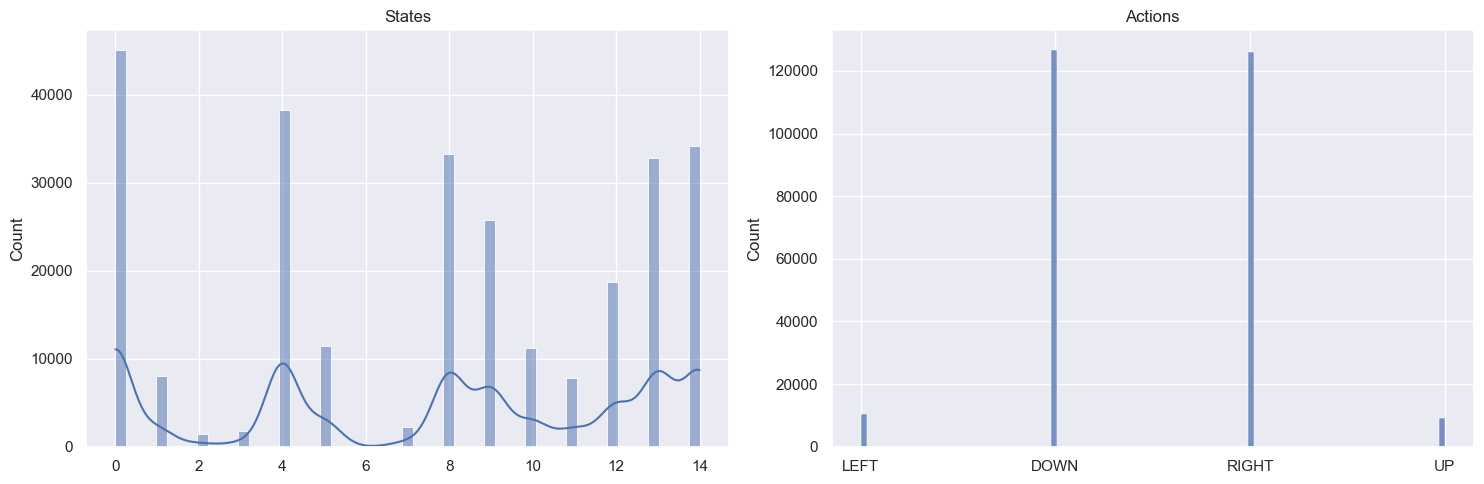

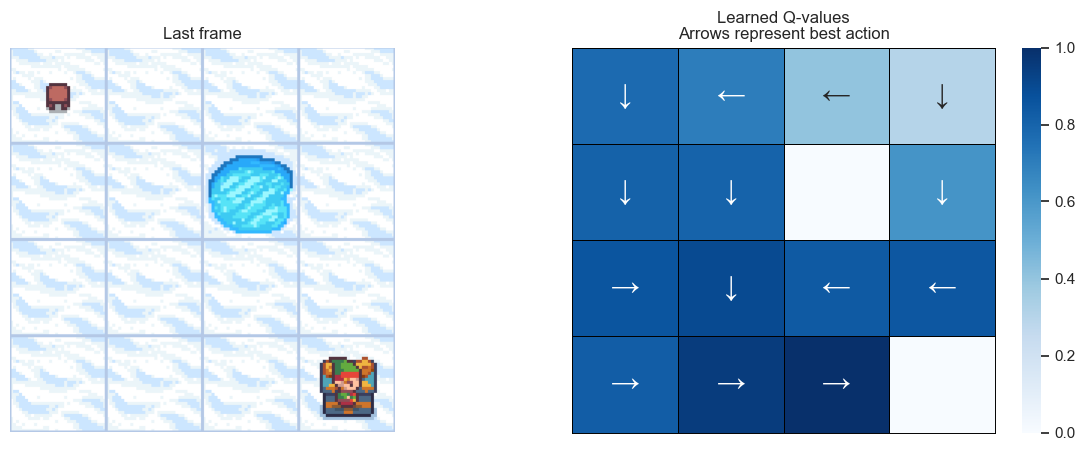

Map size: 7x7


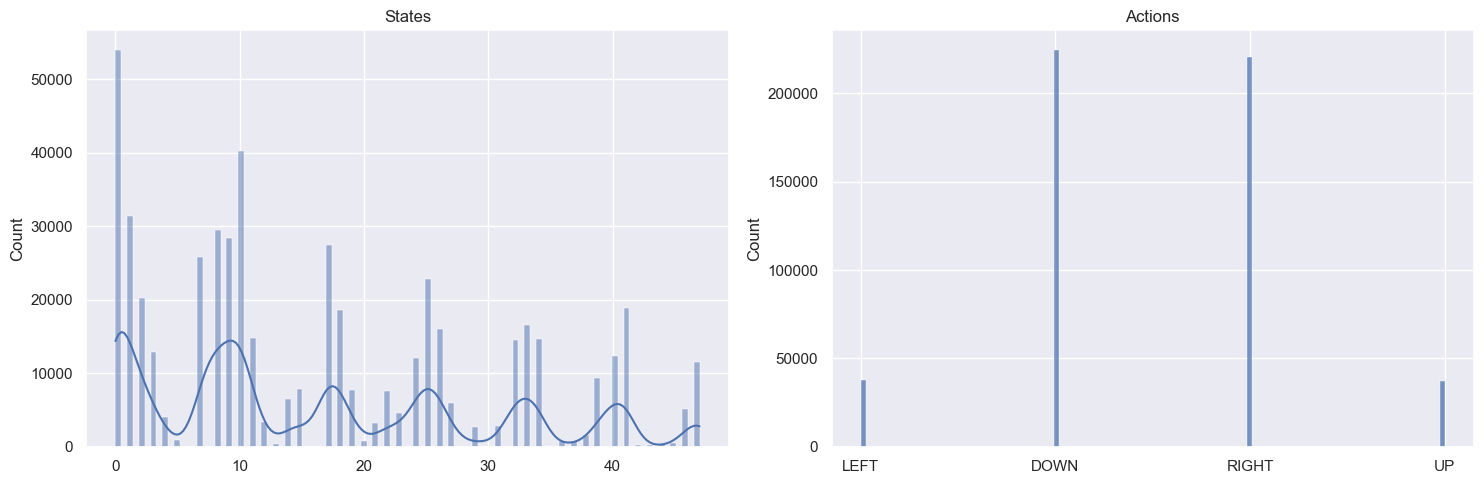

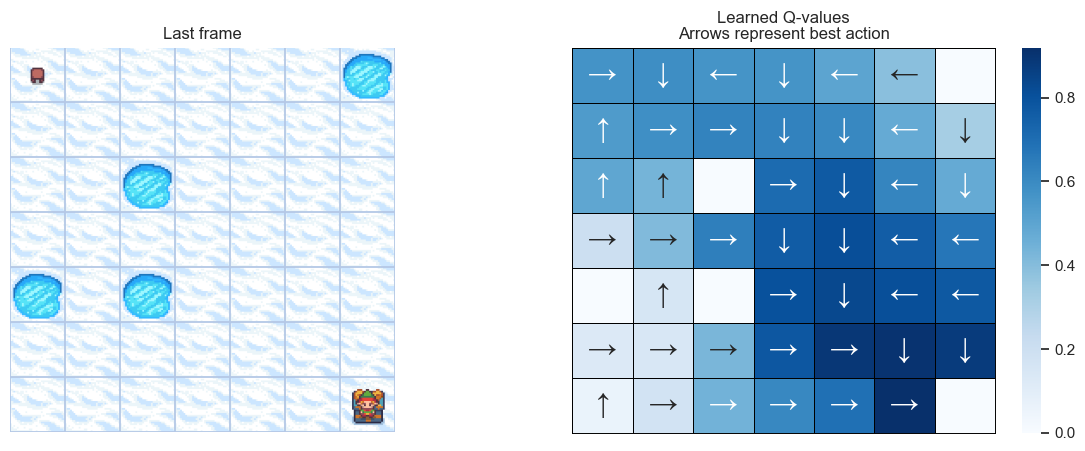

Map size: 9x9


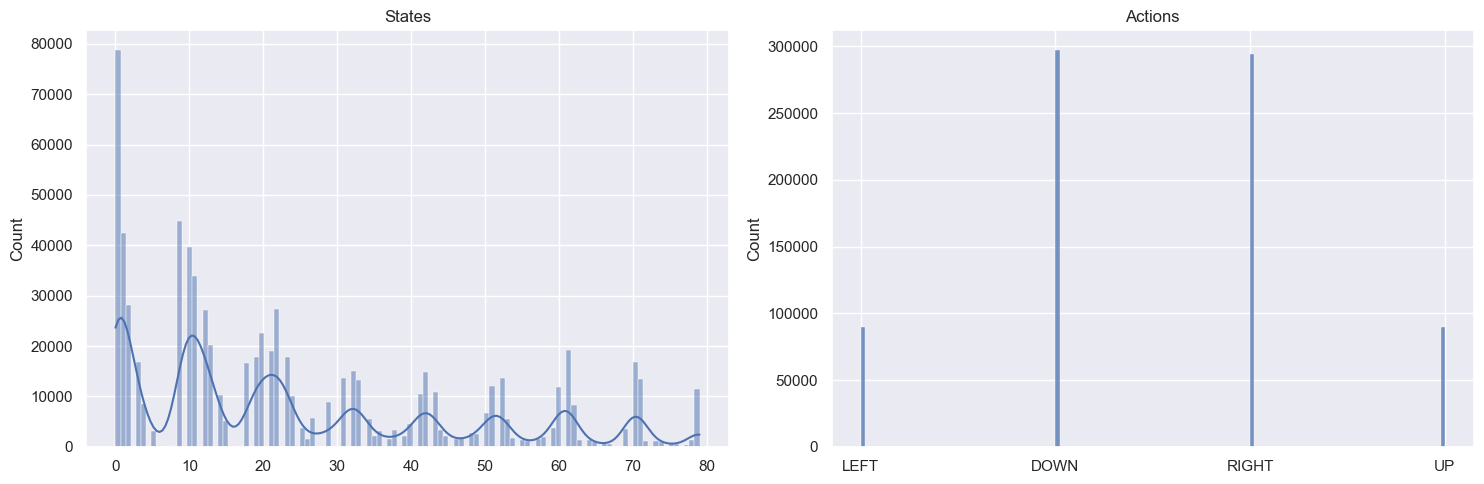

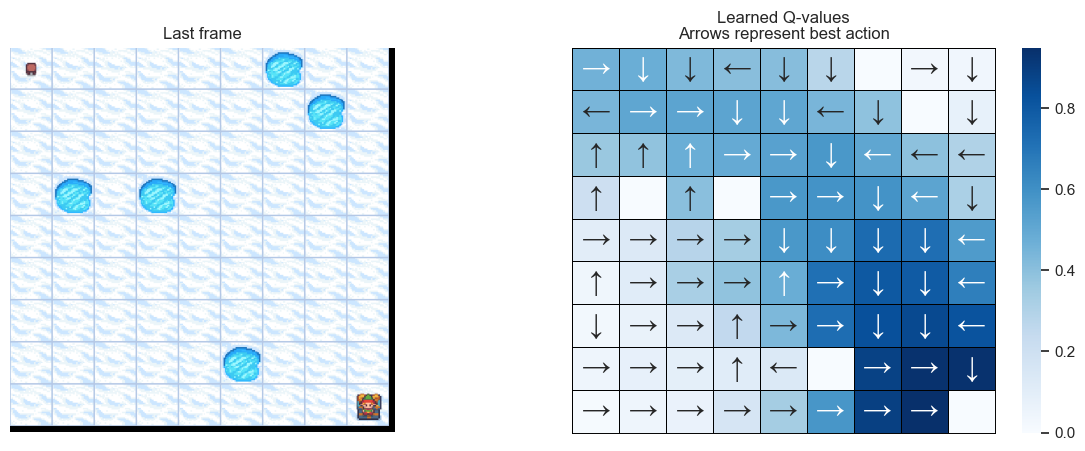

Map size: 11x11


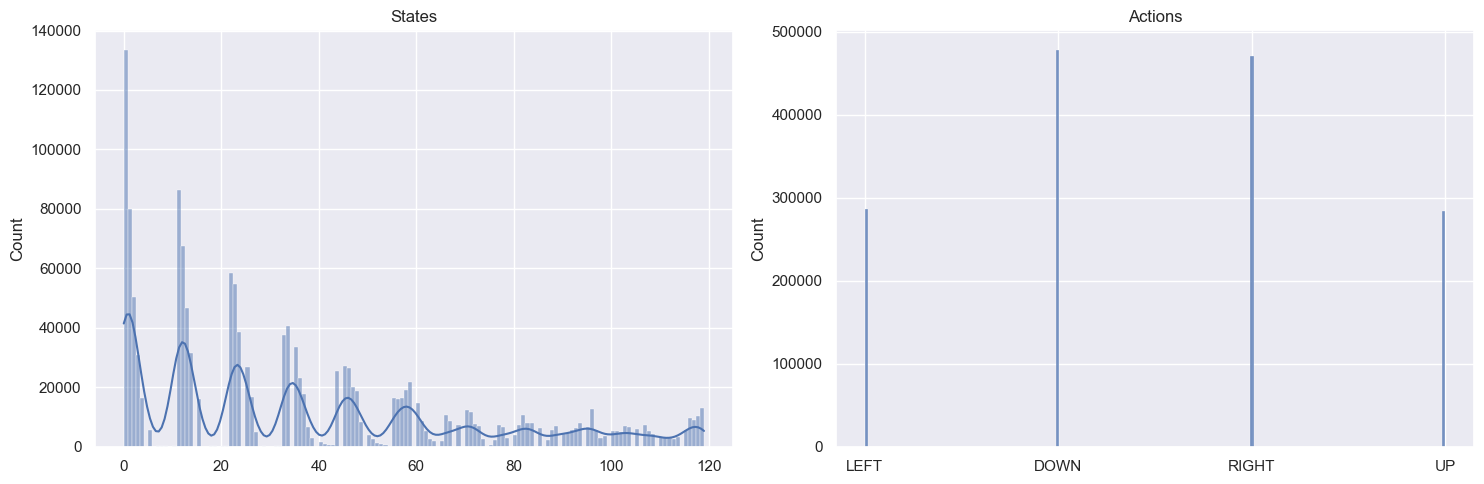

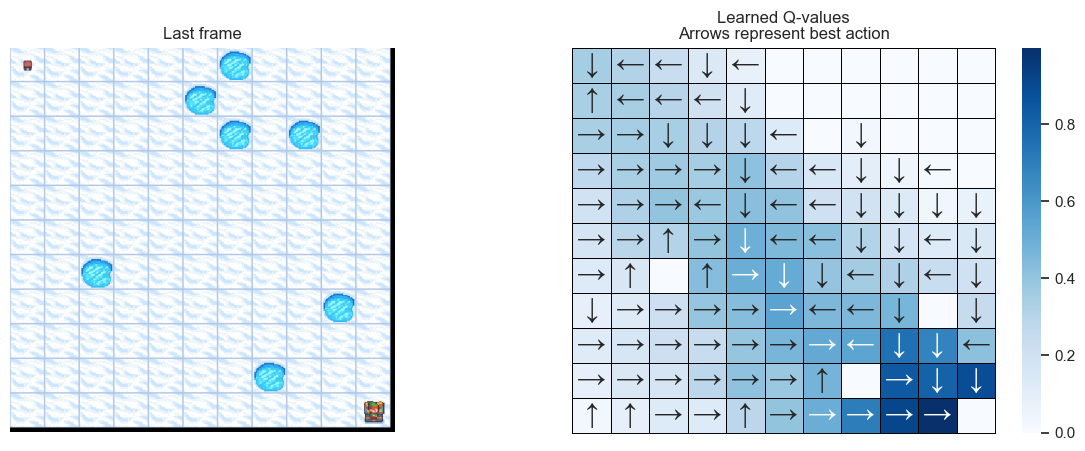

In [11]:
map_sizes = [4, 7, 9, 11]
res_all = pd.DataFrame()
st_all = pd.DataFrame()

for map_size in map_sizes:
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=params.proba_frozen, seed=params.seed
        ),
    )

    params = params._replace(action_size=env.action_space.n)
    params = params._replace(state_size=env.observation_space.n)
    env.action_space.seed(
        params.seed
    )  # Set the seed to get reproducible results when sampling the action space
    learner = Qlearning(
        learning_rate=params.learning_rate,
        gamma=params.gamma,
        state_size=params.state_size,
        action_size=params.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon=params.epsilon,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env()

    # Save the results in dataframes
    res, st = postprocess(episodes, params, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)  # Average the Q-table between runs

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )  # Sanity check
    plot_q_values_map(qtable, env, map_size)

    env.close()

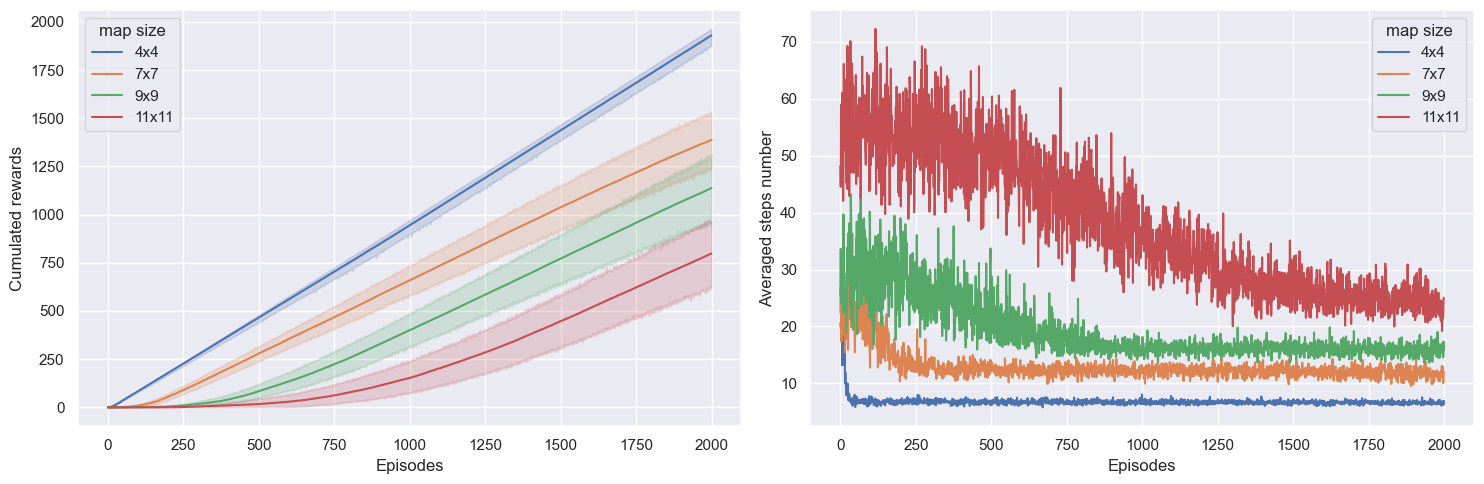

In [12]:
def plot_steps_and_rewards(rewards_df, steps_df):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(
        data=rewards_df, x="Episodes", y="cum_rewards", hue="map_size", ax=ax[0]
    )
    ax[0].set(ylabel="Cumulated rewards")

    sns.lineplot(data=steps_df, x="Episodes", y="Steps", hue="map_size", ax=ax[1])
    ax[1].set(ylabel="Averaged steps number")

    for axi in ax:
        axi.legend(title="map size")
    fig.tight_layout()
    img_title = "frozenlake_steps_and_rewards.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()


plot_steps_and_rewards(res_all, st_all)

### with alpha = 0.7, gamma = 0.90, epsilon = 0.2

In [13]:
class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability
    map_size: int  # Number of tiles of one side of the squared environment
    seed: int  # Define a seed so that we get reproducible results
    is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    proba_frozen: float  # Probability that a tile is frozen
    savefig_folder: Path  # Root folder where plots are saved


params = Params(
    total_episodes=2000,
    learning_rate=0.7,
    gamma=0.9,
    epsilon=0.2,
    map_size=5,
    seed=123,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("../../_static/img/tutorials/"),
)
params

# Set the seed
rng = np.random.default_rng(params.seed)

# Create the figure folder if it doesn't exists
params.savefig_folder.mkdir(parents=True, exist_ok=True)

In [14]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)


In [15]:

params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")


class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((self.state_size, self.action_size))


class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        """Choose an action `a` in the current world state (s)."""
        # First we randomize a number
        explor_exploit_tradeoff = rng.uniform(0, 1)

        # Exploration
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        else:
            # Break ties randomly
            # If all actions are the same for this state we choose a random one
            # (otherwise `np.argmax()` would always take the first one)
            if np.all(qtable[state, :]) == qtable[state, 0]:
                action = action_space.sample()
            else:
                action = np.argmax(qtable[state, :])
        return action

Action size: 4
State size: 25


In [16]:
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)
explorer = EpsilonGreedy(
    epsilon=params.epsilon,
)

In [17]:
def run_env():
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):  # Run several times to account for stochasticity
        learner.reset_qtable()  # Reset the Q-table between runs

        for episode in tqdm(
            episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=params.seed)[0]  # Reset the environment
            step = 0
            done = False
            total_rewards = 0

            while not done:
                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                # Log all states and actions
                all_states.append(state)
                all_actions.append(action)

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )

                total_rewards += reward
                step += 1

                # Our new state is state
                state = new_state

            # Log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

In [18]:
def postprocess(episodes, params, rewards, steps, map_size):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(),
            "Steps": steps.flatten(),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st


In [19]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [20]:
def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

In [21]:
def plot_states_actions_distribution(states, actions, map_size):
    """Plot the distributions of states and actions."""
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    img_title = f"frozenlake_states_actions_distrib_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

Map size: 4x4


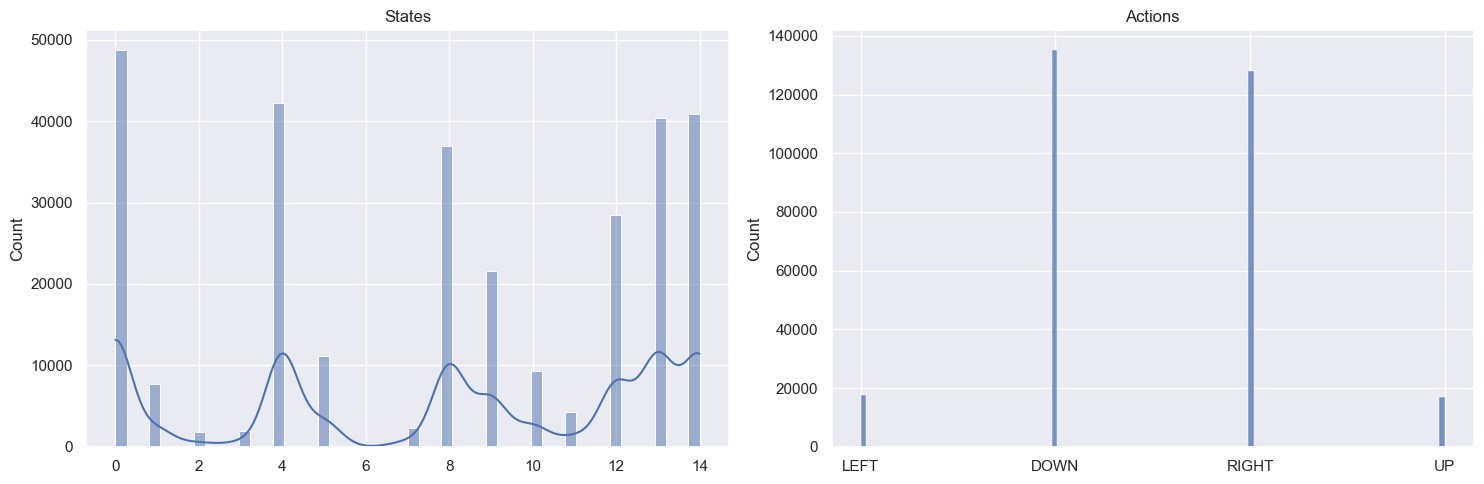

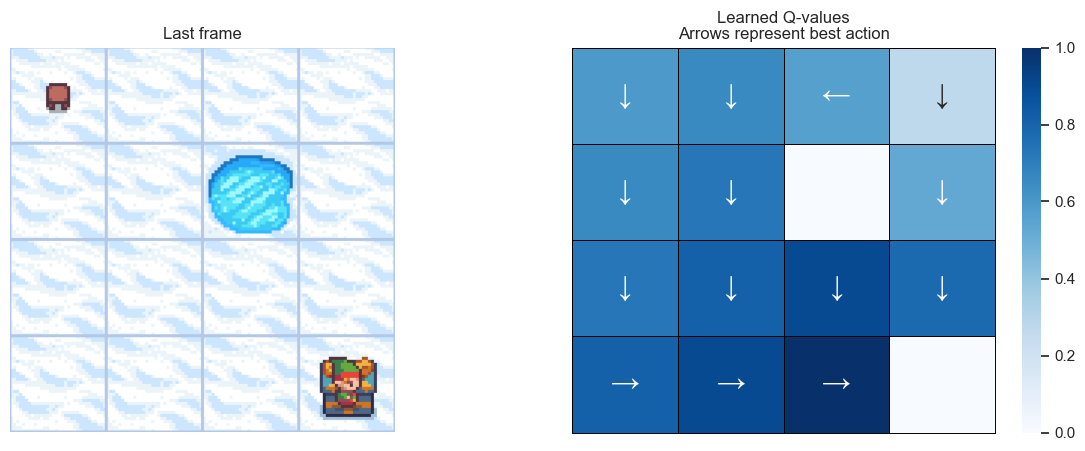

Map size: 7x7


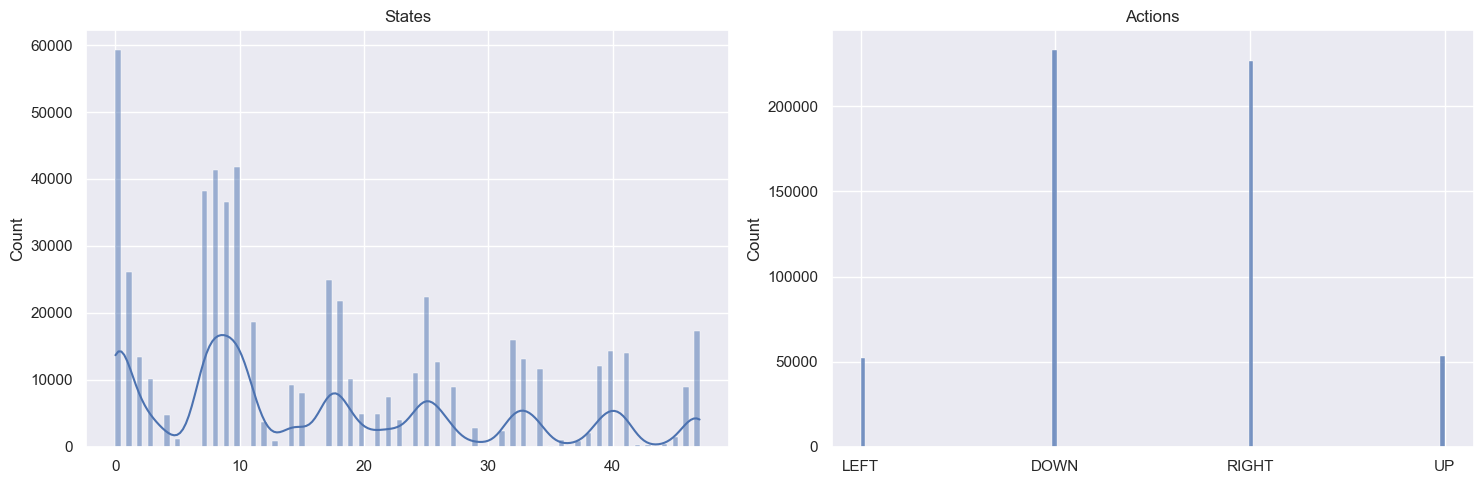

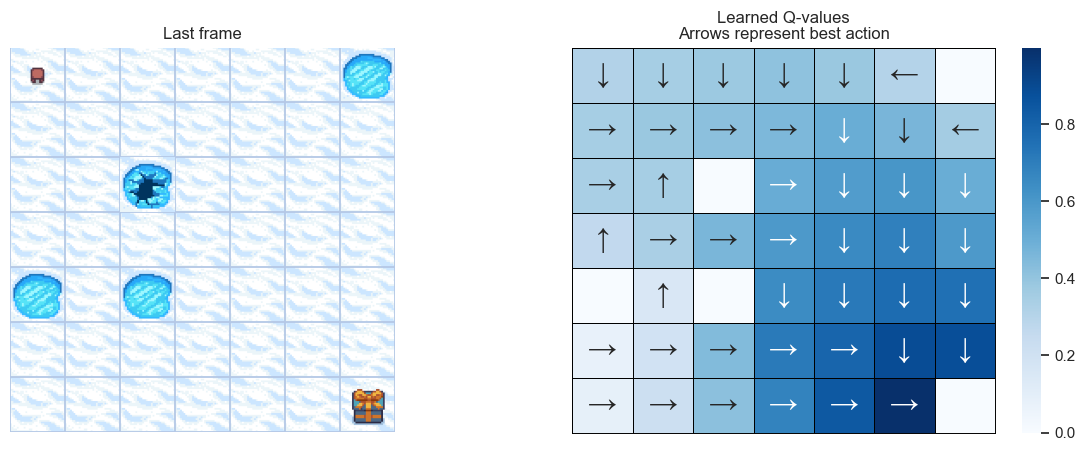

Map size: 9x9


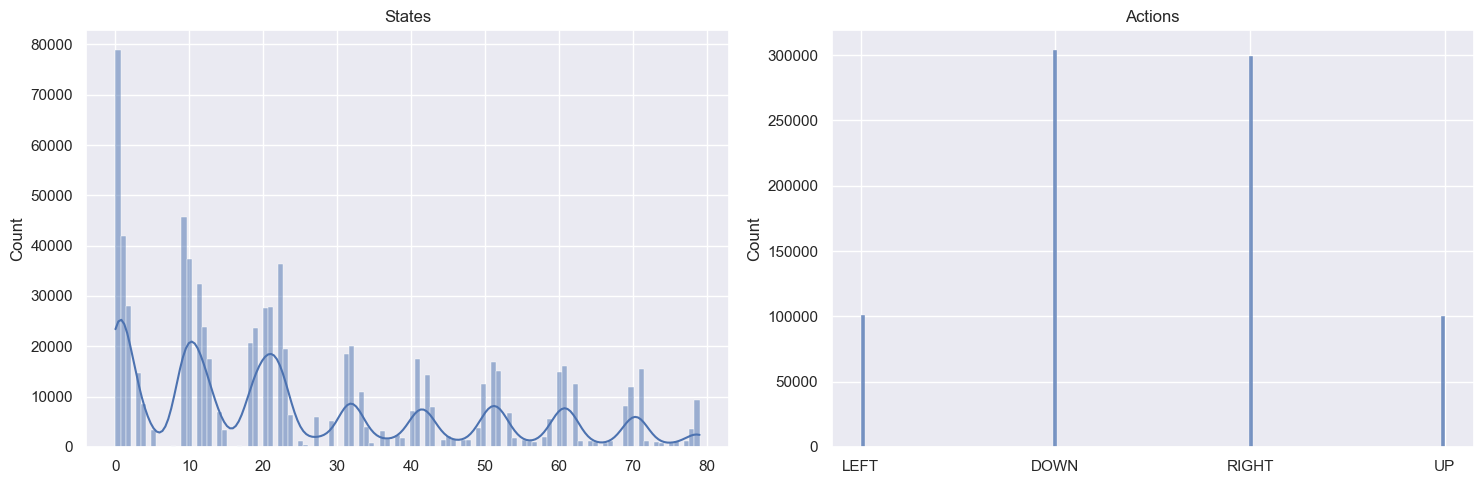

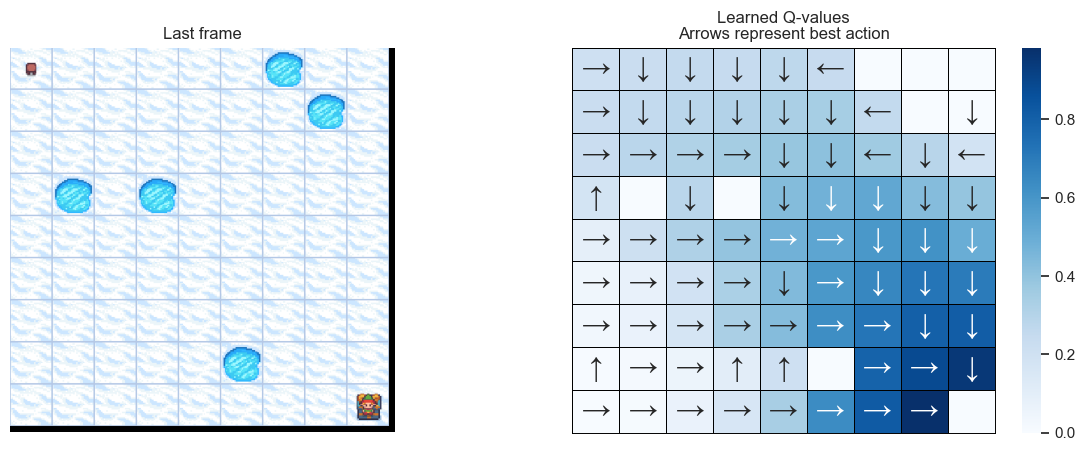

Map size: 11x11


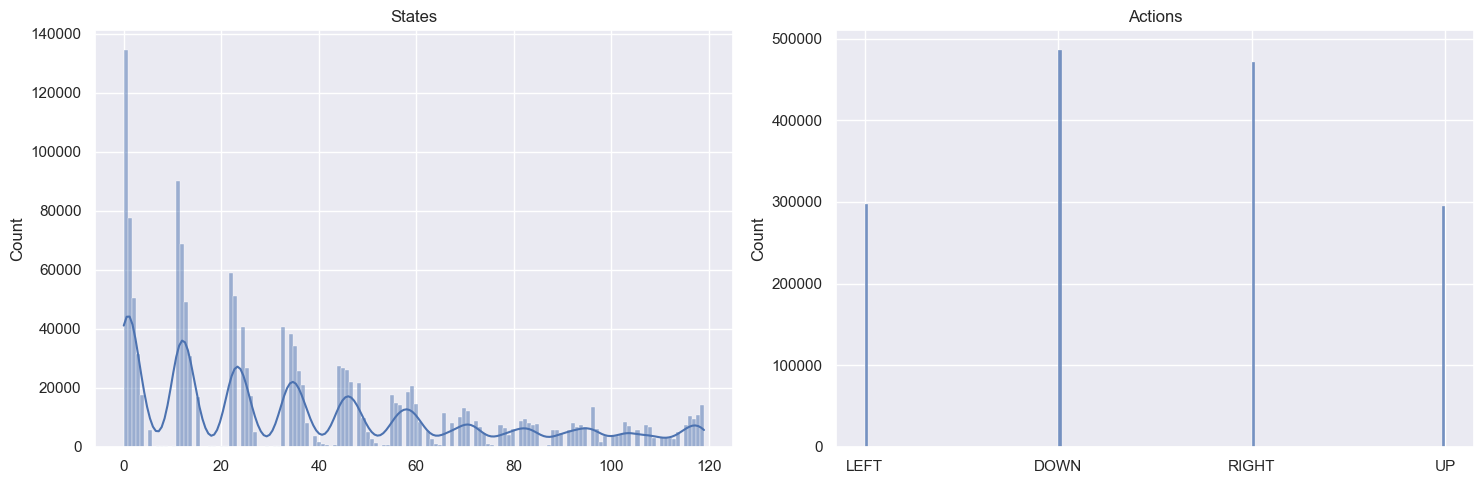

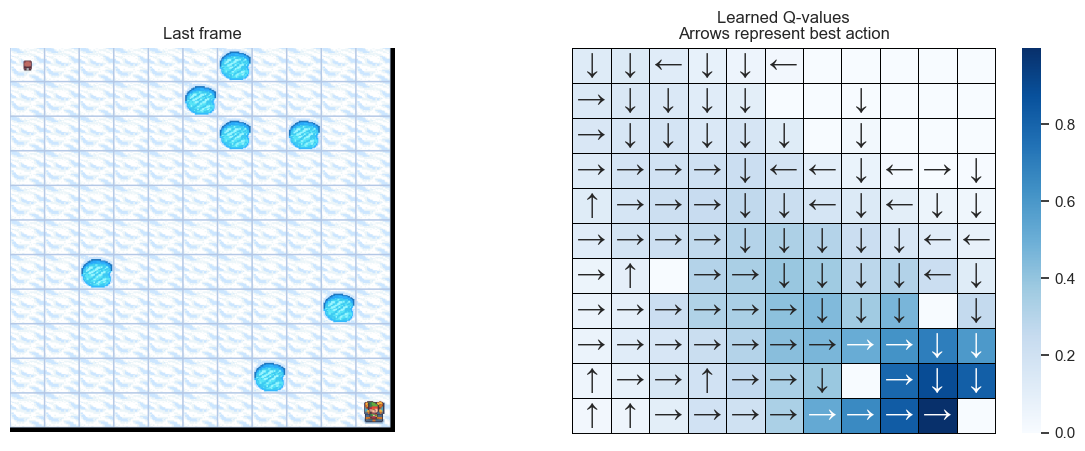

In [22]:
map_sizes = [4, 7, 9, 11]
res_all = pd.DataFrame()
st_all = pd.DataFrame()

for map_size in map_sizes:
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=params.proba_frozen, seed=params.seed
        ),
    )

    params = params._replace(action_size=env.action_space.n)
    params = params._replace(state_size=env.observation_space.n)
    env.action_space.seed(
        params.seed
    )  # Set the seed to get reproducible results when sampling the action space
    learner = Qlearning(
        learning_rate=params.learning_rate,
        gamma=params.gamma,
        state_size=params.state_size,
        action_size=params.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon=params.epsilon,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env()

    # Save the results in dataframes
    res, st = postprocess(episodes, params, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)  # Average the Q-table between runs

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )  # Sanity check
    plot_q_values_map(qtable, env, map_size)

    env.close()

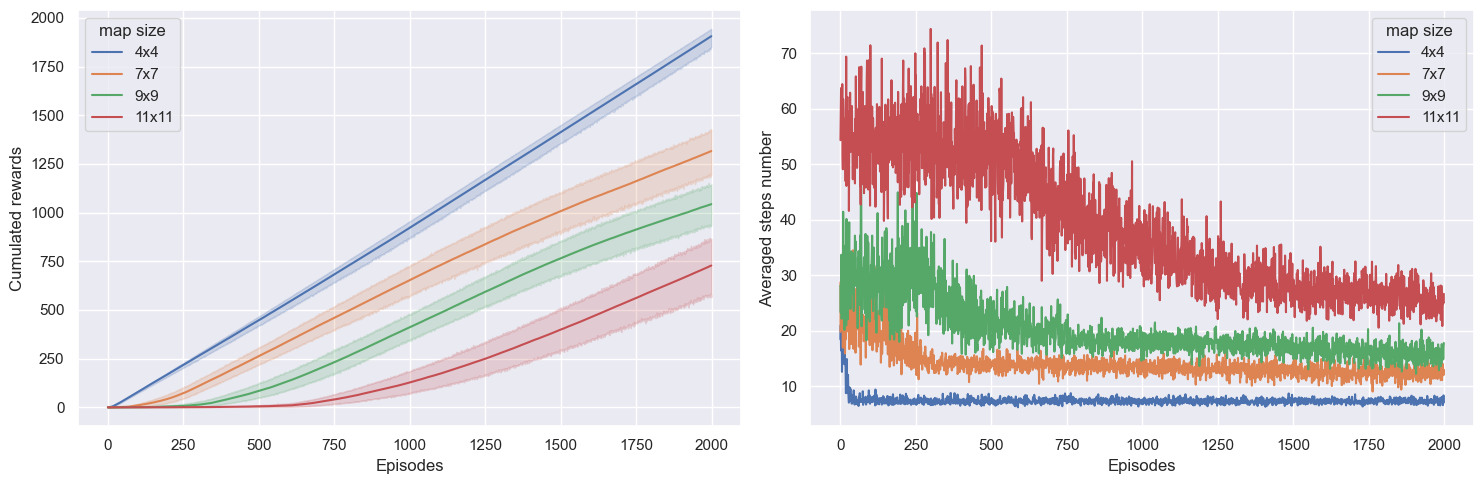

In [23]:
def plot_steps_and_rewards(rewards_df, steps_df):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(
        data=rewards_df, x="Episodes", y="cum_rewards", hue="map_size", ax=ax[0]
    )
    ax[0].set(ylabel="Cumulated rewards")

    sns.lineplot(data=steps_df, x="Episodes", y="Steps", hue="map_size", ax=ax[1])
    ax[1].set(ylabel="Averaged steps number")

    for axi in ax:
        axi.legend(title="map size")
    fig.tight_layout()
    img_title = "frozenlake_steps_and_rewards.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()


plot_steps_and_rewards(res_all, st_all)

### with alpha = 0.5, gamma = 0.70, epsilon = 0.09

In [24]:
class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability
    map_size: int  # Number of tiles of one side of the squared environment
    seed: int  # Define a seed so that we get reproducible results
    is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    proba_frozen: float  # Probability that a tile is frozen
    savefig_folder: Path  # Root folder where plots are saved


params = Params(
    total_episodes=2000,
    learning_rate=0.5,
    gamma=0.70,
    epsilon=0.09,
    map_size=5,
    seed=123,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("../../_static/img/tutorials/"),
)
params

# Set the seed
rng = np.random.default_rng(params.seed)

# Create the figure folder if it doesn't exists
params.savefig_folder.mkdir(parents=True, exist_ok=True)

In [25]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)


In [26]:

params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")


class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((self.state_size, self.action_size))


class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        """Choose an action `a` in the current world state (s)."""
        # First we randomize a number
        explor_exploit_tradeoff = rng.uniform(0, 1)

        # Exploration
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        else:
            # Break ties randomly
            # If all actions are the same for this state we choose a random one
            # (otherwise `np.argmax()` would always take the first one)
            if np.all(qtable[state, :]) == qtable[state, 0]:
                action = action_space.sample()
            else:
                action = np.argmax(qtable[state, :])
        return action

Action size: 4
State size: 25


In [27]:
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)
explorer = EpsilonGreedy(
    epsilon=params.epsilon,
)

In [28]:
def run_env():
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):  # Run several times to account for stochasticity
        learner.reset_qtable()  # Reset the Q-table between runs

        for episode in tqdm(
            episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=params.seed)[0]  # Reset the environment
            step = 0
            done = False
            total_rewards = 0

            while not done:
                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                # Log all states and actions
                all_states.append(state)
                all_actions.append(action)

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )

                total_rewards += reward
                step += 1

                # Our new state is state
                state = new_state

            # Log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

In [29]:
def postprocess(episodes, params, rewards, steps, map_size):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(),
            "Steps": steps.flatten(),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st


In [30]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [31]:
def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

In [32]:
def plot_states_actions_distribution(states, actions, map_size):
    """Plot the distributions of states and actions."""
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    img_title = f"frozenlake_states_actions_distrib_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

Map size: 4x4


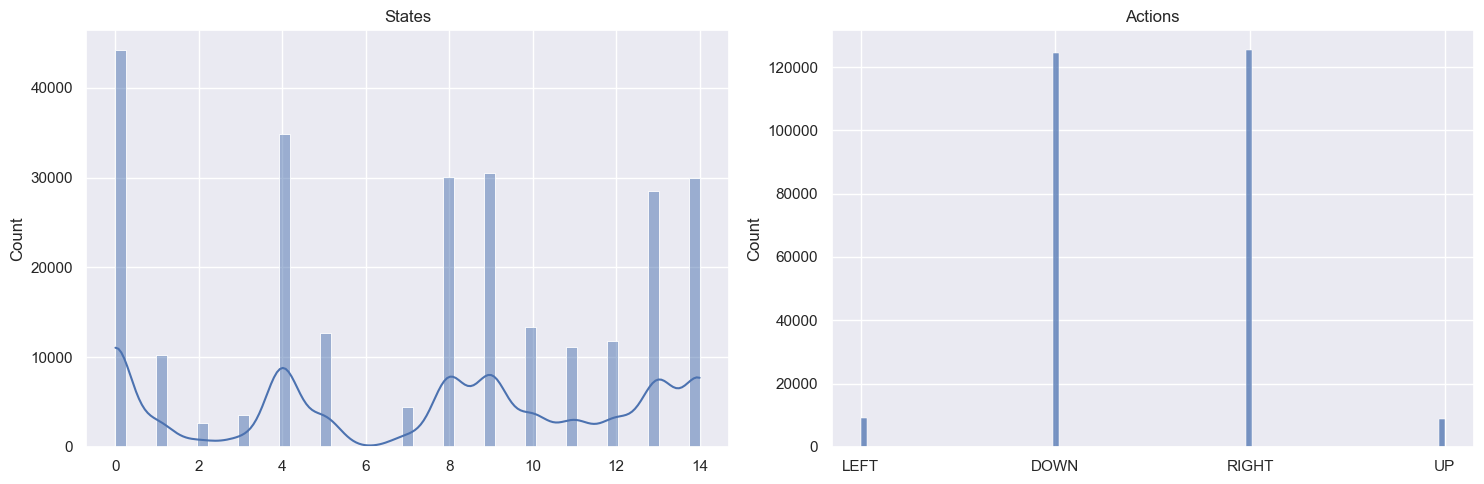

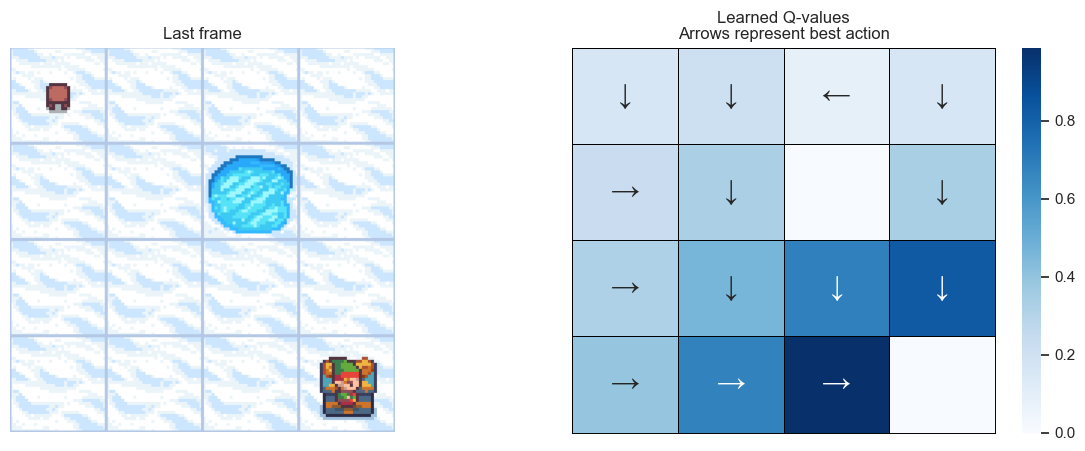

Map size: 7x7


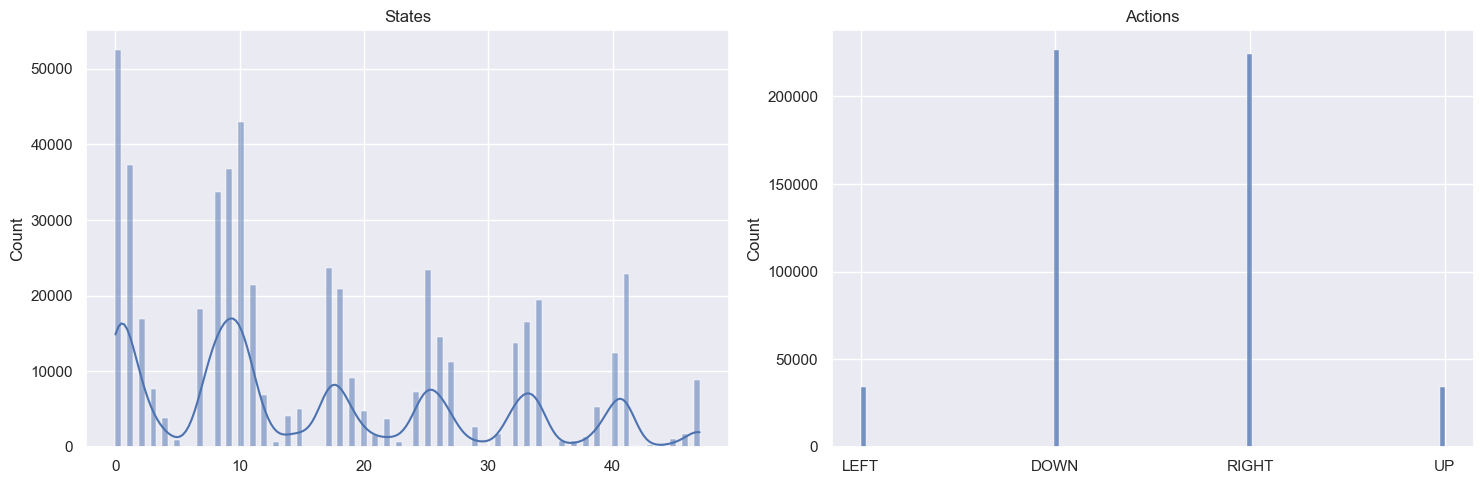

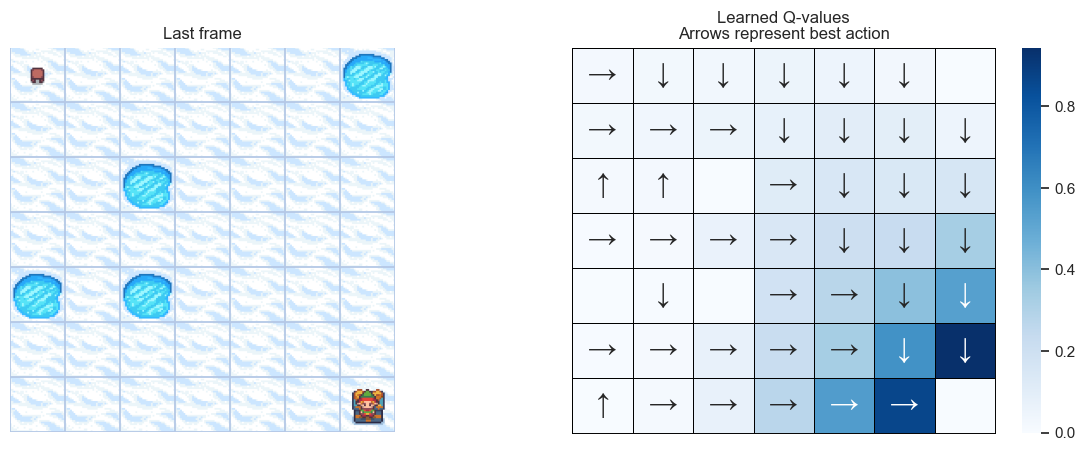

Map size: 9x9


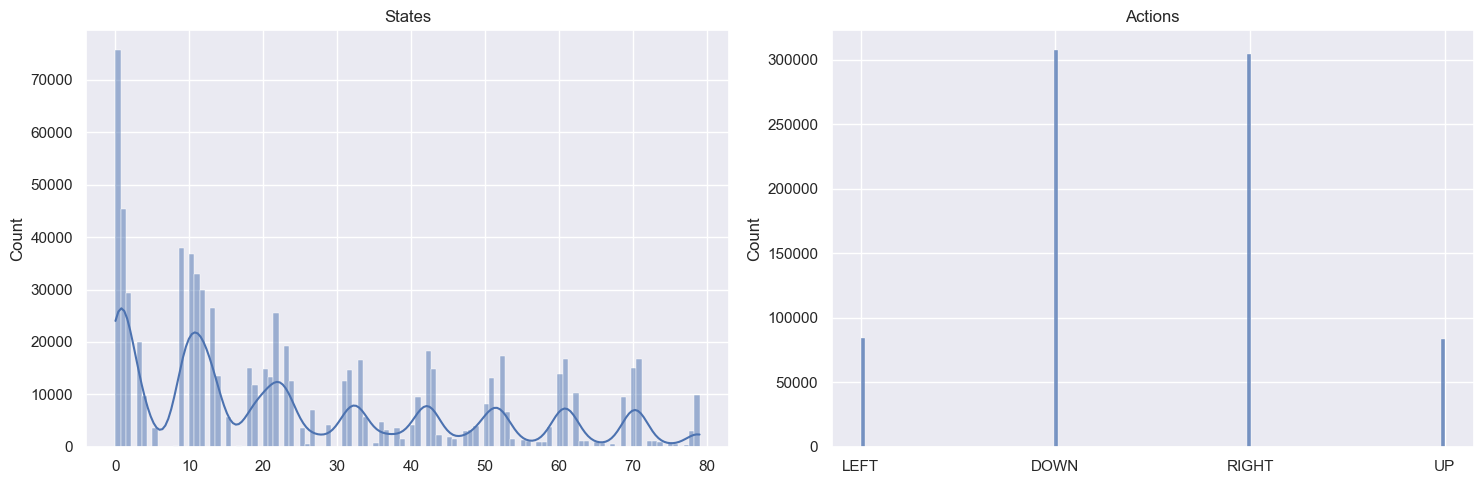

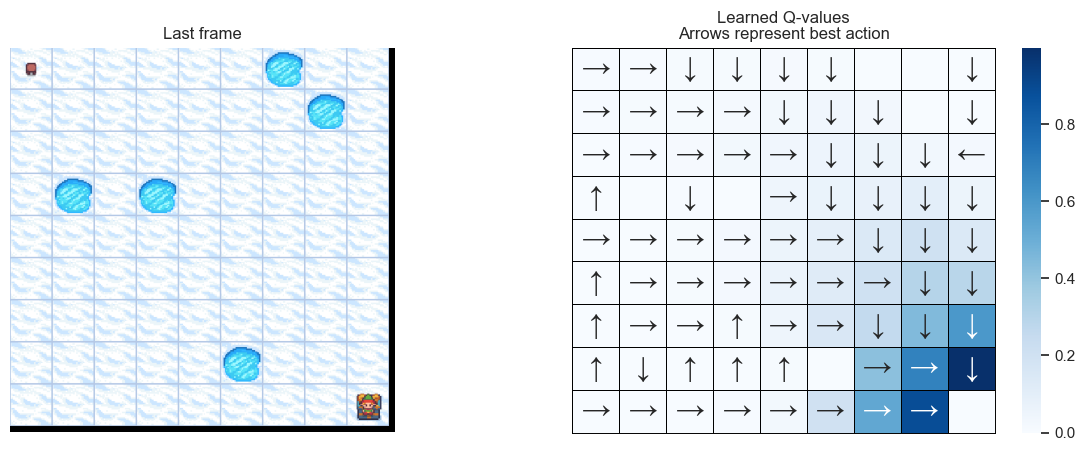

Map size: 11x11


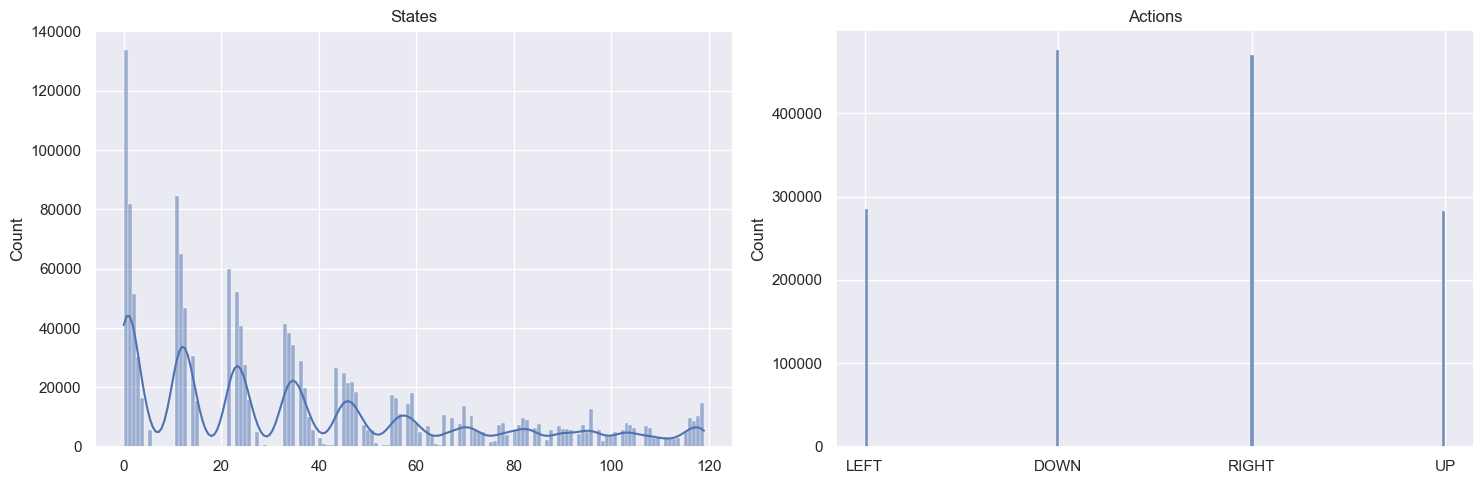

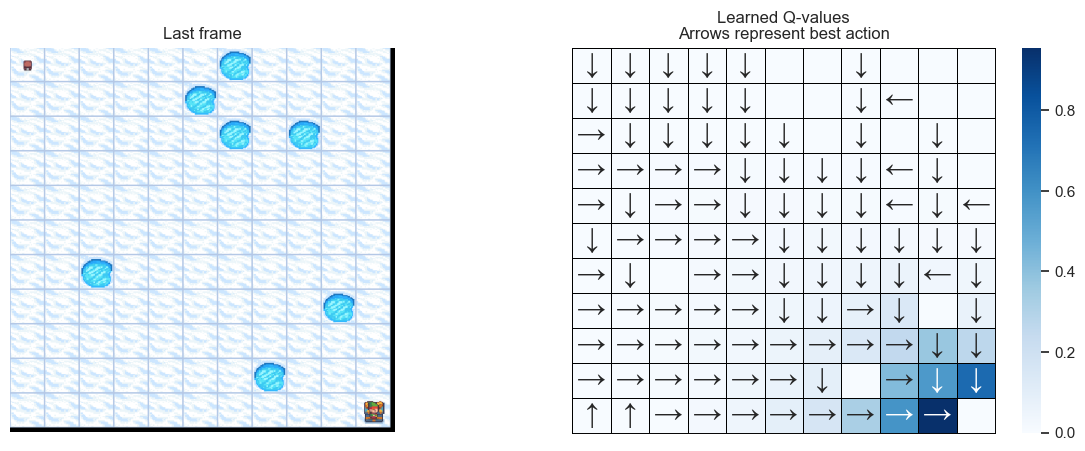

In [33]:
map_sizes = [4, 7, 9, 11]
res_all = pd.DataFrame()
st_all = pd.DataFrame()

for map_size in map_sizes:
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=params.proba_frozen, seed=params.seed
        ),
    )

    params = params._replace(action_size=env.action_space.n)
    params = params._replace(state_size=env.observation_space.n)
    env.action_space.seed(
        params.seed
    )  # Set the seed to get reproducible results when sampling the action space
    learner = Qlearning(
        learning_rate=params.learning_rate,
        gamma=params.gamma,
        state_size=params.state_size,
        action_size=params.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon=params.epsilon,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env()

    # Save the results in dataframes
    res, st = postprocess(episodes, params, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)  # Average the Q-table between runs

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )  # Sanity check
    plot_q_values_map(qtable, env, map_size)

    env.close()

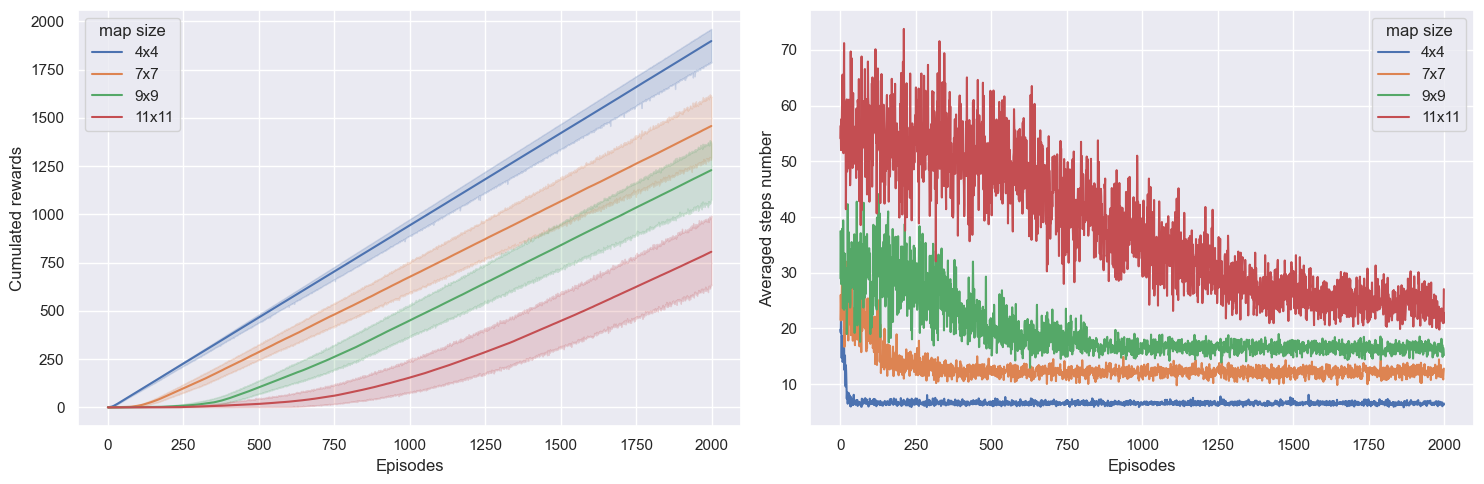

In [34]:
def plot_steps_and_rewards(rewards_df, steps_df):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(
        data=rewards_df, x="Episodes", y="cum_rewards", hue="map_size", ax=ax[0]
    )
    ax[0].set(ylabel="Cumulated rewards")

    sns.lineplot(data=steps_df, x="Episodes", y="Steps", hue="map_size", ax=ax[1])
    ax[1].set(ylabel="Averaged steps number")

    for axi in ax:
        axi.legend(title="map size")
    fig.tight_layout()
    img_title = "frozenlake_steps_and_rewards.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()


plot_steps_and_rewards(res_all, st_all)

### policy iteration algorithm on frozen lake environment

In [35]:
import numpy as np
import gym

def policy_evaluation(env, policy, V, gamma, theta):
    while True:
        delta = 0
        for s in range(env.observation_space.n):
            v = V[s]
            V[s] = sum([p * (r + gamma * V[s_next]) for p, s_next, r, _ in env.P[s][policy[s]]])
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break

def policy_improvement(env, policy, V, gamma):
    policy_stable = True
    for s in range(env.observation_space.n):
        old_action = policy[s]
        q_values = [sum([p * (r + gamma * V[s_next]) for p, s_next, r, _ in env.P[s][a]]) for a in range(env.action_space.n)]
        policy[s] = np.argmax(q_values)
        if old_action != policy[s]:
            policy_stable = False
    return policy_stable

def policy_iteration(env, gamma, theta):
    policy = np.random.choice(env.action_space.n, size=env.observation_space.n)  # Initialize random policy
    V = np.zeros(env.observation_space.n)  # Initialize value function

    while True:
        policy_evaluation(env, policy, V, gamma, theta)
        if policy_improvement(env, policy, V, gamma):
            break
    
    return policy, V

# Create the FrozenLake environment
env = gym.make('FrozenLake-v1')

# Set the discount factor and convergence threshold
gamma = 0.99
theta = 1e-6

# Run policy iteration
optimal_policy, optimal_value = policy_iteration(env, gamma, theta)

print("Optimal policy:", optimal_policy)
print("Optimal value function:", optimal_value)


Optimal policy: [0 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0]
Optimal value function: [0.54201384 0.49878716 0.47067695 0.45683159 0.55844022 0.
 0.35833998 0.         0.59178998 0.64307352 0.61520205 0.
 0.         0.7417161  0.86283524 0.        ]


### Part 2

In [36]:
import gym
import numpy as np
import random
import pickle
from collections import deque

# hyperparameters
EPISODES = 1000
LEARNING_RATE = 0.9
GAMMA = 0.90
EPSILON = 0.8
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.999
REPLAY_MEMORY_SIZE = 1000000
BATCH_SIZE = 20
UPDATE_TARGET_EVERY = 5
MIN_REPLAY_MEMORY_SIZE = 1000

# agent class
class Agent:
    def __init__(self, action_size, state_size):
        self.action_size = action_size
        self.epsilon = EPSILON
        self.gamma = GAMMA
        self.learning_rate = LEARNING_RATE
        self.q_table = np.zeros((state_size, action_size))

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state_index = self.state_to_index(state)
        return np.argmax(self.q_table[state_index])

    def state_to_index(self, state):
        state_str = ','.join(map(str, state))
        state_hash = hash(state_str)
        return state_hash % len(self.q_table)

    def update_q_table(self, state, action, reward, next_state):
        state_index = self.state_to_index(state)
        next_state_index = self.state_to_index(next_state)
        old_value = self.q_table[state_index, action]
        next_max = np.max(self.q_table[next_state_index])
        new_value = (1 - self.learning_rate) * old_value + self.learning_rate * (reward + self.gamma * next_max)
        self.q_table[state_index, action] = new_value

    def update_epsilon(self):
        if self.epsilon > EPSILON_MIN:
            self.epsilon *= EPSILON_DECAY

    #// plot the rewards
    def plot_rewards(self, episode_rewards):
        plt.plot(episode_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.show()


def preprocess_image(image):
    image = image[35:195]
    image = image[::2,::2,0]
    image[image == 144] = 0
    image[image == 109] = 0
    image[image != 0] = 1
    return image.astype(float).ravel()

def main():
    env = gym.make('Pong-v0')
    env.seed(0)
    np.random.seed(0)
    
    agent = Agent(6, 80*80*1)
    
    episode_rewards = []
    
    for episode in range(EPISODES):
        episode_reward = 0
        current_state_tuple = env.reset()
        current_state = preprocess_image(current_state_tuple[0])  # Access the first element of the tuple
        done = False
        
        while not done:
            action = agent.get_action(current_state)
            step_result = env.step(action)
            new_state = preprocess_image(step_result[0])
            reward = step_result[1]
            done = step_result[2]
            agent.update_q_table(current_state, action, reward, new_state)
            current_state = new_state
            episode_reward += reward
        
        agent.update_epsilon()
        episode_rewards.append(episode_reward)
        
        print(f'Episode: {episode}, Reward: {episode_reward}')
    
    with open('q_table.pkl', 'wb') as f:
        pickle.dump(agent.q_table, f)
    
    env.close()

if __name__ == '__main__':
    main()



/opt/homebrew/anaconda3/envs/ml/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Pong-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Episode: 0, Reward: -21.0
Episode: 1, Reward: -20.0
Episode: 2, Reward: -21.0
Episode: 3, Reward: -21.0
Episode: 4, Reward: -21.0
Episode: 5, Reward: -21.0
Episode: 6, Reward: -21.0
Episode: 7, Reward: -20.0
Episode: 8, Reward: -21.0
Episode: 9, Reward: -20.0
Episode: 10, Reward: -18.0
Episode: 11, Reward: -21.0
Episode: 12, Reward: -21.0
Episode: 13, Reward: -21.0
Episode: 14, Reward: -21.0
Episode: 15, Reward: -21.0
Episode: 16, Reward: -19.0
Episode: 17, Reward: -21.0
Episode: 18, Reward: -19.0
Episode: 19, Reward: -21.0
Episode: 20, Reward: -21.0
Episode: 21, Reward: -21.0
Episode: 22, Reward: -21.0
Episode: 23, Reward: -20.0
Episode: 24, Reward: -21.0
Episode: 25, Reward: -21.0
Episode: 26, Reward: -21.0
Episode: 27, Reward: -20.0
Episode: 28, Reward: -19.0
Episode: 29, Reward: -21.0
Episode: 30, Reward: -20.0
Episode: 31, Reward: -20.0
Episode: 32, Reward: -21.0
Episode: 33, Reward: -21.0
Episode: 34, Reward: -20.0
Episode: 35, Reward: -20.0
Episode: 36, Reward: -20.0
Episode: 37

In [38]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import gym
from skimage.transform import resize
from skimage.color import rgb2gray

# Set random seeds
np.random.seed(1)
tf.random.set_seed(1)

# Define the PPO class
class PPO:
    def __init__(self, n_actions, lr, gamma, epsilon, batch_size, n_hidden, n_layers):
        self.n_actions = n_actions
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.n_hidden = n_hidden
        self.n_layers = n_layers

        # Define the actor and critic networks
        self.actor = self.build_net(scope='Actor')
        self.critic = self.build_net(scope='Critic')

        # Define optimizers
        self.actor_optimizer = tf.keras.optimizers.Adam(self.lr)
        self.critic_optimizer = tf.keras.optimizers.Adam(self.lr)

        # Initialize memory
        self.memory = []

    def build_net(self, scope):
        model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(84, 84, 1)),
            tf.keras.layers.Conv2D(32, (8, 8), strides=(4, 4), activation='relu'),
            tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(self.n_hidden, activation='relu'),
            tf.keras.layers.Dense(self.n_hidden, activation='relu'),
            tf.keras.layers.Dense(self.n_hidden, activation='relu')  # Add another layer
        ])
        value = tf.keras.layers.Dense(1, activation='linear')  # Output a single value for critic
        model.add(value)
        return model


    def choose_action(self, state):
        logits = self.actor(state)
        dist = tfp.distributions.Categorical(logits=logits)
        action = dist.sample()
        return int(action.numpy()[0])


    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def learn(self):
        # Sample a batch from memory
        indices = np.random.choice(len(self.memory), self.batch_size, replace=False)
        batch = [self.memory[i] for i in indices]
        state_batch = np.array([item[0] for item in batch])
        action_batch = np.array([item[1] for item in batch])
        reward_batch = np.array([item[2] for item in batch])
        next_state_batch = np.array([item[3] for item in batch])
        done_batch = np.array([item[4] for item in batch])

        # Convert rewards to discounted cumulative rewards
        discounted_rewards = []
        cumulative_reward = 0
        for reward, done in zip(reward_batch[::-1], done_batch[::-1]):
            cumulative_reward = reward + self.gamma * cumulative_reward * (1 - done)
            discounted_rewards.insert(0, cumulative_reward)
        discounted_rewards = np.array(discounted_rewards)

        # Compute advantages (you can implement GAE here)
        advantage_batch = discounted_rewards - self.critic(state_batch).numpy().flatten()

        # Update actor and critic networks
        with tf.GradientTape() as tape:
            # Compute actor loss
            logits = self.actor(state_batch, training=True)
            dist = tfp.distributions.Categorical(logits=logits)
            old_dist = tfp.distributions.Categorical(logits=self.actor(state_batch, training=False))
            old_log_probs = old_dist.log_prob(action_batch)
            log_probs = dist.log_prob(action_batch)
            ratio = tf.exp(log_probs - old_log_probs)
            surrogate1 = ratio * advantage_batch
            surrogate2 = tf.clip_by_value(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantage_batch
            actor_loss = -tf.reduce_mean(tf.minimum(surrogate1, surrogate2))

            # Compute critic loss
            value_predictions = self.critic(state_batch, training=True)
            critic_loss = tf.reduce_mean(tf.square(discounted_rewards - value_predictions))
        
            # Total loss
            total_loss = actor_loss + critic_loss

        # Update networks
        gradients = tape.gradient(total_loss, self.actor.trainable_variables + self.critic.trainable_variables)
        actor_gradients = gradients[:len(self.actor.trainable_variables)]
        critic_gradients = gradients[len(self.actor.trainable_variables):]
        self.actor_optimizer.apply_gradients(zip(actor_gradients, self.actor.trainable_variables))
        self.critic_optimizer.apply_gradients(zip(critic_gradients, self.critic.trainable_variables))


# Create Pong environment
env = gym.make('Pong-v0')

# Get environment parameters
n_actions = env.action_space.n

# Create PPO agent
ppo_agent = PPO(n_actions=n_actions, lr=0.8, gamma=0.9, epsilon=0.2, batch_size=64, n_hidden=64, n_layers=2)

# ...
# Training loop
num_episodes = 1000
for episode in range(num_episodes):
    state_tuple = env.reset()  # Reset the environment
    total_reward = 0

    done = False
    while not done:
        state_image = state_tuple[0]  # Extract the image data from the tuple
        state_preprocessed = state_image[35:195, :]  # Crop the unnecessary parts of the screen
        state_preprocessed = np.mean(state_preprocessed, axis=1)  # Convert to grayscale
        state_preprocessed = state_preprocessed.astype(np.float32) / 255.0
        state_preprocessed = resize(state_preprocessed, (84, 84, 1))  # Resize to (84, 84, 1)

        action = ppo_agent.choose_action(np.expand_dims(state_preprocessed, axis=0))
        next_state_tuple, reward, done, _, _ = env.step(action)  # Unpack next_state, reward, done

        total_reward += reward

        # Preprocess the next state
        next_state_image = next_state_tuple[0]
        next_state_preprocessed = next_state_image[35:195, :]
        next_state_preprocessed = np.mean(next_state_preprocessed, axis=1)
        next_state_preprocessed = next_state_preprocessed.astype(np.float32) / 255.0
        next_state_preprocessed = resize(next_state_preprocessed, (84, 84, 1))

        # Store transition
        ppo_agent.store_transition(state_preprocessed, action, reward, next_state_preprocessed, done)

        state_tuple = next_state_tuple

    # Learn from experiences
    ppo_agent.learn()

    print(f"Episode: {episode+1}, Total Reward: {total_reward}")

# Close the environment
env.close()


Episode: 1, Total Reward: -21.0
Episode: 2, Total Reward: -21.0
Episode: 3, Total Reward: -21.0
Episode: 4, Total Reward: -21.0
Episode: 5, Total Reward: -21.0
Episode: 6, Total Reward: -21.0
Episode: 7, Total Reward: -21.0


KeyboardInterrupt: 

## Refferences:
1. http://www.sagargv.com/blog/pong-ppo/
2. https://github.com/handolpark/udacity-deep-reinforcement-learning/blob/master/pong/pong-PPO.ipynb
3. https://medium.com/analytics-vidhya/beating-pong-using-reinforcement-learning-part-2-a2c-and-ppo-b83391dd3657
4. https://coax.readthedocs.io/en/latest/examples/getting_started/third_agent.html
5. https://towardsdatascience.com/a-graphic-guide-to-implementing-ppo-for-atari-games-5740ccbe3fbc
6. https://towardsdatascience.com/intro-to-reinforcement-learning-pong-92a94aa0f84d
7. https://pylessons.com/DQN-PONG